<a href="https://colab.research.google.com/github/SihaAma/Medical_image_segmentaion/blob/main/3D_CT_Lung_Registration_and_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 718 kB 4.3 MB/s 


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import torch
from torch.nn import MSELoss
from monai.apps import download_url, download_and_extract
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.losses import BendingEnergyLoss, MultiScaleLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.nets import LocalNet
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    RandAffined,
    Resized,
    ScaleIntensityRanged,
    EnsureTyped,
)
from monai.utils import set_determinism, first

print_config()

MONAI version: 0.9.dev2152
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: c5bd8aff8ba461d7b349eb92427d452481a7eb72

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpgeqt0rnr


In [4]:
resource = "https://zenodo.org/record/3835682/files/training.zip"

compressed_file = os.path.join(root_dir, "paired_ct_lung.zip")
data_dir = os.path.join(root_dir, "paired_ct_lung")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)
    os.rename(os.path.join(root_dir, "training"), data_dir)

paired_ct_lung.zip: 266MB [01:02, 4.49MB/s]                           

2022-01-01 20:41:42,777 - INFO - Downloaded: /tmp/tmpgeqt0rnr/paired_ct_lung.zip
2022-01-01 20:41:42,781 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpgeqt0rnr/paired_ct_lung.zip.
2022-01-01 20:41:42,782 - INFO - Writing into directory: /tmp/tmpgeqt0rnr.


In [5]:
data_dicts = [
    {
        "fixed_image": os.path.join(data_dir,
                                    "scans/case_%03d_exp.nii.gz" % idx),
        "moving_image": os.path.join(data_dir,
                                     "scans/case_%03d_insp.nii.gz" % idx),
        "fixed_label": os.path.join(data_dir,
                                    "lungMasks/case_%03d_exp.nii.gz" % idx),
        "moving_label": os.path.join(data_dir,
                                     "lungMasks/case_%03d_insp.nii.gz" % idx),
    }
    for idx in range(1, 21)
]

train_files, val_files = data_dicts[:18], data_dicts[18:]

In [6]:
set_determinism(seed=0)

In [7]:
train_transforms = Compose(
    [
        LoadImaged(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
        AddChanneld(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-285, a_max=3770, b_min=0.0, b_max=1.0, clip=True,
        ),
        RandAffined(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=('bilinear', 'bilinear', 'nearest', 'nearest'),
            prob=1.0, spatial_size=(192, 192, 208),
            rotate_range=(0, 0, np.pi / 15), scale_range=(0.1, 0.1, 0.1)
        ),
        Resized(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=('trilinear', 'trilinear', 'nearest', 'nearest'),
            align_corners=(True, True, None, None),
            spatial_size=(96, 96, 104)
        ),
        EnsureTyped(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
        AddChanneld(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-285, a_max=3770, b_min=0.0, b_max=1.0,
            clip=True,
        ),
        Resized(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=('trilinear', 'trilinear', 'nearest', 'nearest'),
            align_corners=(True, True, None, None),
            spatial_size=(96, 96, 104)
        ),
        EnsureTyped(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
    ]
)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


moving_image shape: torch.Size([96, 96, 104]), moving_label shape: torch.Size([96, 96, 104])
fixed_image shape: torch.Size([96, 96, 104]), fixed_label shape: torch.Size([96, 96, 104])


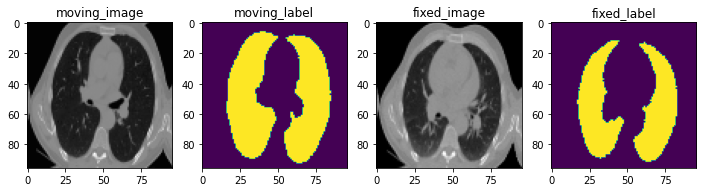

In [8]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
fixed_image = check_data["fixed_image"][0][0].permute(1, 0, 2)
fixed_label = check_data["fixed_label"][0][0].permute(1, 0, 2)
moving_image = check_data["moving_image"][0][0].permute(1, 0, 2)
moving_label = check_data["moving_label"][0][0].permute(1, 0, 2)

print(f"moving_image shape: {moving_image.shape}, "
      f"moving_label shape: {moving_label.shape}")
print(f"fixed_image shape: {fixed_image.shape}, "
      f"fixed_label shape: {fixed_label.shape}")

# plot the slice [:, :, 50]
plt.figure("check", (12, 6))
plt.subplot(1, 4, 1)
plt.title("moving_image")
plt.imshow(moving_image[:, :, 50], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("moving_label")
plt.imshow(moving_label[:, :, 50])
plt.subplot(1, 4, 3)
plt.title("fixed_image")
plt.imshow(fixed_image[:, :, 50], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("fixed_label")
plt.imshow(fixed_label[:, :, 50])

plt.show()
plt.show()

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,
                        cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms,
                      cache_rate=1.0, num_workers=0)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


In [13]:
# standard PyTorch program style: create LocalNet, losses and optimizer
device = torch.device("cuda")
model = LocalNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    num_channel_initial=32,
    extract_levels=[0, 1, 2, 3],
    out_activation=None,
    out_kernel_initializer="zeros").to(device)
warp_layer = Warp().to(device)
image_loss = MSELoss()
label_loss = DiceLoss()
label_loss = MultiScaleLoss(label_loss, scales=[0, 1, 2, 4, 8, 16])
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

/usr/local/lib/python3.7/dist-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


In [14]:
def forward(batch_data, model):
    fixed_image = batch_data["fixed_image"].to(device)
    moving_image = batch_data["moving_image"].to(device)
    moving_label = batch_data["moving_label"].to(device)

    # predict DDF through LocalNet
    ddf = model(torch.cat((moving_image, fixed_image), dim=1))

    # warp moving image and label with the predicted ddf
    pred_image = warp_layer(moving_image, ddf)
    pred_label = warp_layer(moving_label, ddf)

    return ddf, pred_image, pred_label

In [15]:
max_epochs = 1
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    if (epoch + 1) % val_interval == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:

                val_ddf, val_pred_image, val_pred_label = forward(
                    val_data, model)

                val_fixed_image = val_data["fixed_image"].to(device)
                val_fixed_label = val_data["fixed_label"].to(device)
                dice_metric(y_pred=val_pred_label, y=val_fixed_label)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} "
                f"current mean dice: {metric:.4f}\n"
                f"best mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        ddf, pred_image, pred_label = forward(batch_data, model)

        fixed_image = batch_data["fixed_image"].to(device)
        fixed_label = batch_data["fixed_label"].to(device)
        loss = image_loss(pred_image, fixed_image) + 100 * \
            label_loss(pred_label, fixed_label) + 10 * regularization(ddf)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

/usr/local/lib/python3.7/dist-packages/monai/metrics/meandice.py:73: UserWarning: y_pred should be a binarized tensor.
  warnings.warn("y_pred should be a binarized tensor.")


saved new best metric model
current epoch: 1 current mean dice: 0.7976
best mean dice: 0.7976 at epoch: 1
----------
epoch 1/1
epoch 1 average loss: 38.7084


In [16]:
print(f"train completed, "
      f"best_metric: {best_metric:.4f}  "
      f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7976  at epoch: 1


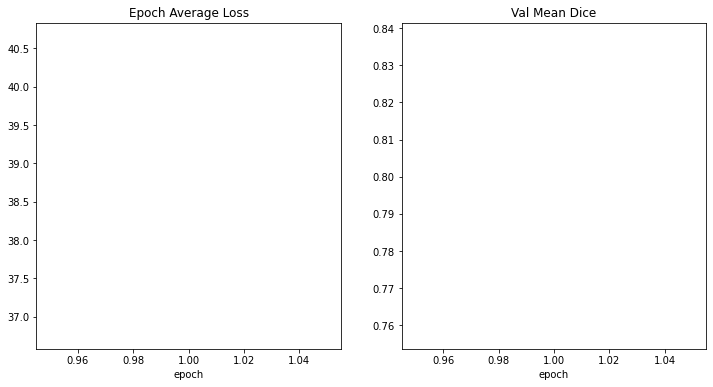

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [18]:
#use pre-trained model
resource = "https://drive.google.com/uc?id=1SUS8qknkxyF_lRLmjNqMz_DvH3Nygj68"
dst = f"{root_dir}/pretrained_weight.pth"
download_url(resource, dst)
model.load_state_dict(torch.load(dst))

Downloading...
From: https://drive.google.com/uc?id=1SUS8qknkxyF_lRLmjNqMz_DvH3Nygj68
To: /tmp/tmpu6gwae_5/pretrained_weight.pth
100%|██████████| 12.1M/12.1M [00:00<00:00, 40.1MB/s]

2022-01-01 21:05:30,625 - INFO - Downloaded: /tmp/tmpgeqt0rnr/pretrained_weight.pth
2022-01-01 21:05:30,627 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpgeqt0rnr/pretrained_weight.pth.


<All keys matched successfully>

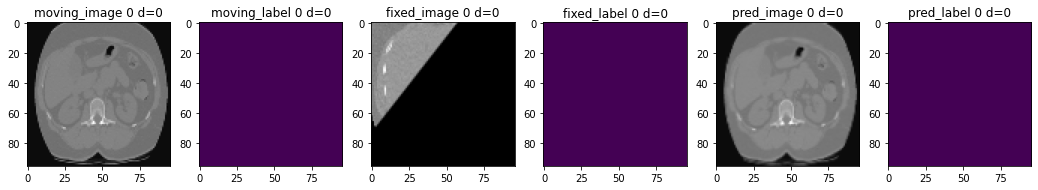

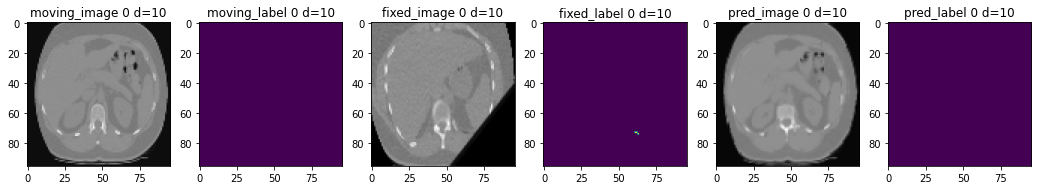

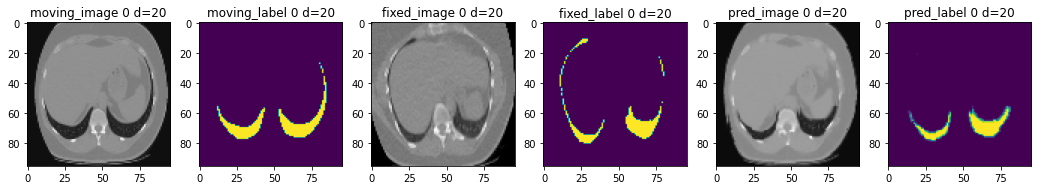

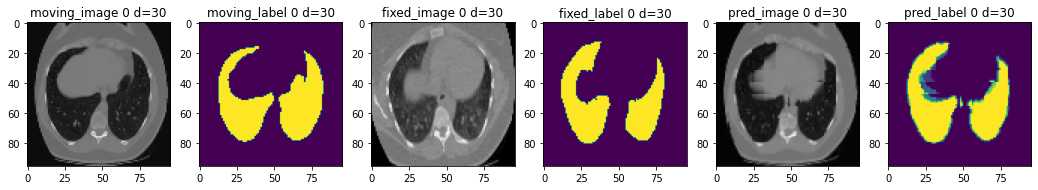

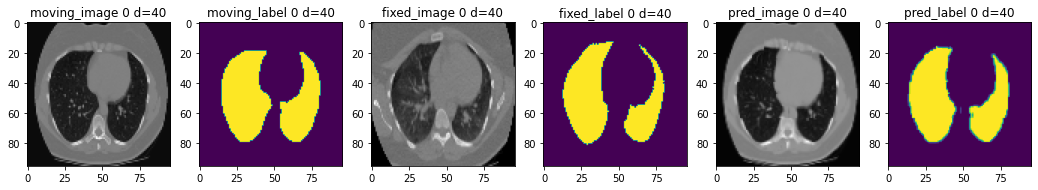

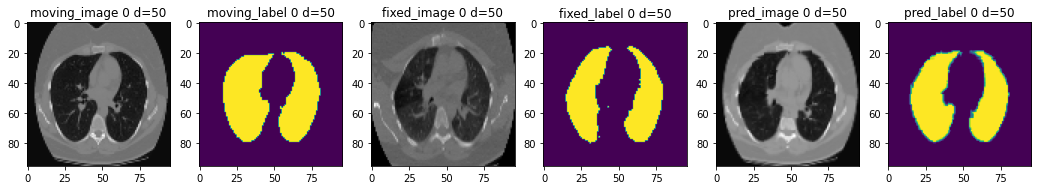

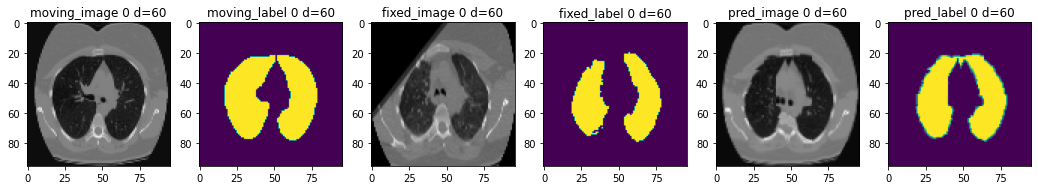

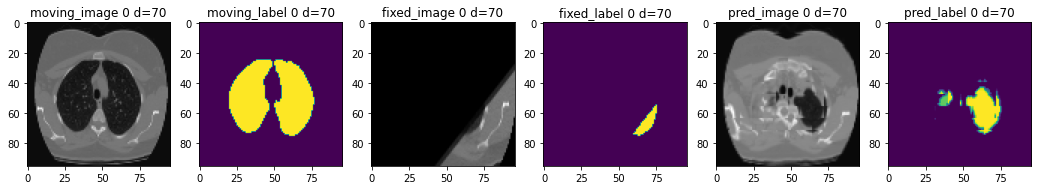

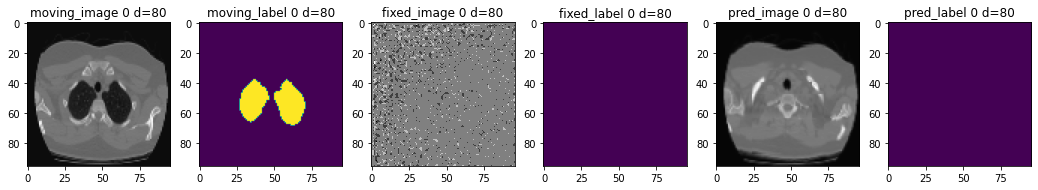

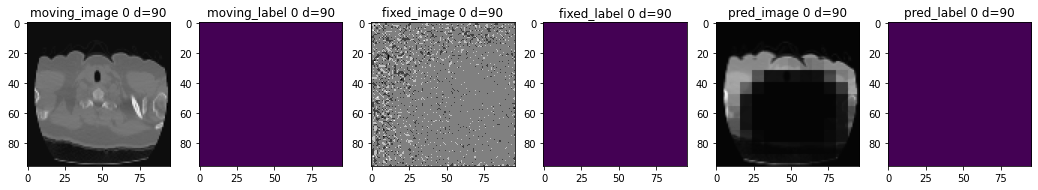

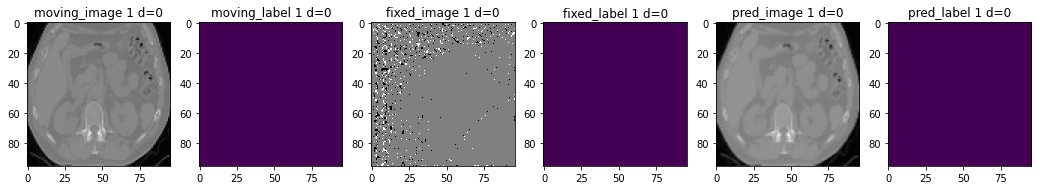

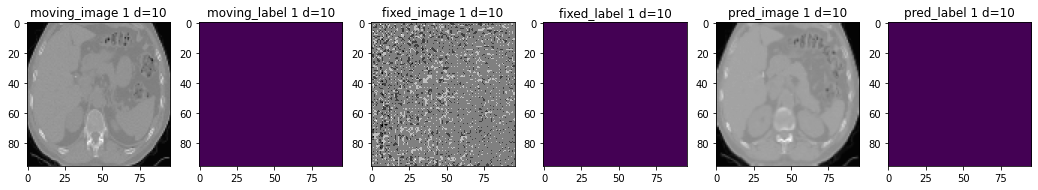

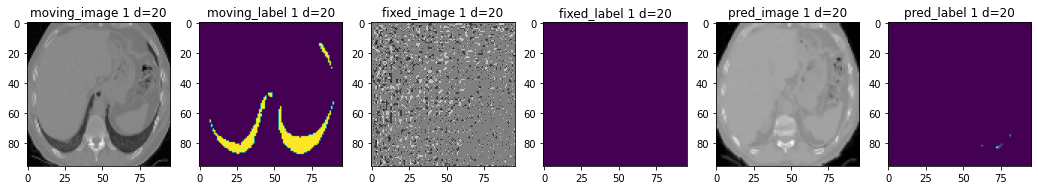

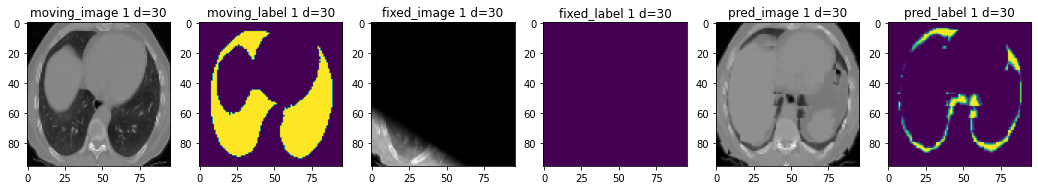

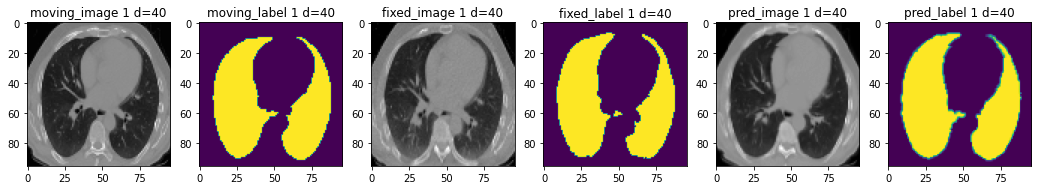

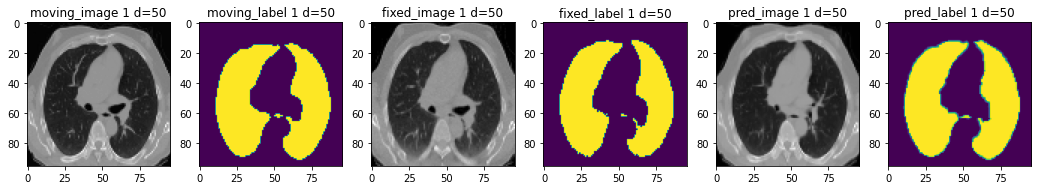

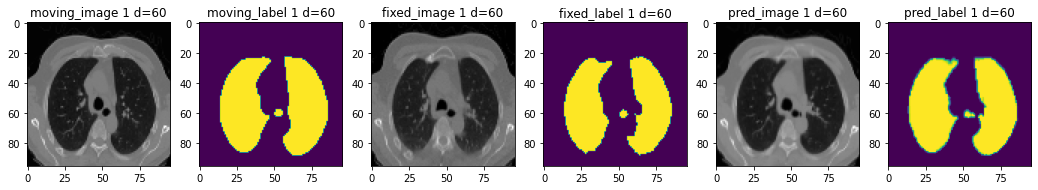

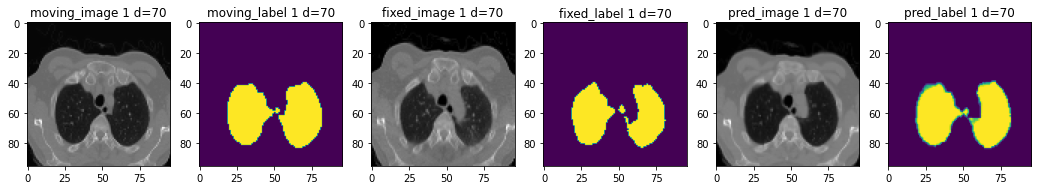

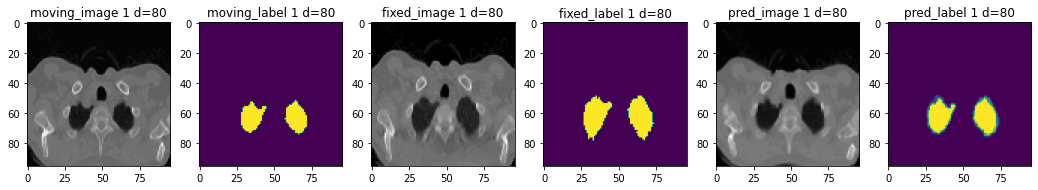

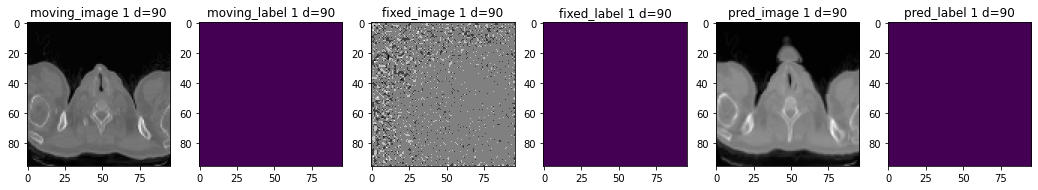

In [19]:
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i > 2:
            break
        val_ddf, val_pred_image, val_pred_label = forward(val_data, model)
        val_pred_image = val_pred_image.cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_pred_label = val_pred_label.cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_moving_image = val_data["moving_image"].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_moving_label = val_data["moving_label"].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_fixed_image = val_data["fixed_image"].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_fixed_label = val_data["fixed_label"].cpu().numpy()[0, 0].transpose((1, 0, 2))

        for depth in range(10):
            depth = depth * 10
            # plot the slice [:, :, 80]
            plt.figure("check", (18, 6))
            plt.subplot(1, 6, 1)
            plt.title(f"moving_image {i} d={depth}")
            plt.imshow(val_moving_image[:, :, depth], cmap="gray")
            plt.subplot(1, 6, 2)
            plt.title(f"moving_label {i} d={depth}")
            plt.imshow(val_moving_label[:, :, depth])
            plt.subplot(1, 6, 3)
            plt.title(f"fixed_image {i} d={depth}")
            plt.imshow(val_fixed_image[:, :, depth], cmap="gray")
            plt.subplot(1, 6, 4)
            plt.title(f"fixed_label {i} d={depth}")
            plt.imshow(val_fixed_label[:, :, depth])
            plt.subplot(1, 6, 5)
            plt.title(f"pred_image {i} d={depth}")
            plt.imshow(val_pred_image[:, :, depth], cmap="gray")
            plt.subplot(1, 6, 6)
            plt.title(f"pred_label {i} d={depth}")
            plt.imshow(val_pred_label[:, :, depth])
            plt.show()

In [20]:
if directory is None:
    shutil.rmtree(root_dir)